# <span style="color: IndianRed;"> 0. Loading Libraries

In [4]:
# Import Libraries
import prophet
from prophet import Prophet
from datetime import date, time
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time
from pandas.tseries.offsets import *
from datetime import datetime, timezone
from functools import reduce
import plotly.graph_objects as go
import statistics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import uuid
import warnings
warnings.filterwarnings("ignore")

# <span style="color: IndianRed;"> 1. Data Preprocessing

### <span style="color: LightSalmon;"> 1.1 External Regressors & Exchange Rates </span>

In [5]:
# Get and clean data
def get_forex_data(start_date=pd.to_datetime('2010-01-01'), end_date=date.today(),
                  tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X']):

    # get and concatenate YFinance data
    forex_df_list = []
    for ticker in tickers_to_download:
      ts = yf.download(ticker, start_date, end_date)['Close']
      ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')
      forex_df_list.append(ts)
    forex_df = pd.concat(forex_df_list, axis=1)

    # Clean nan
    forex_rate_df_clean = forex_df.dropna(axis=0)

    return forex_rate_df_clean

In [6]:
forex_df = get_forex_data()
forex_df.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2023-06-12,1.075095,1.258099,0.90320,139.371002,149.820007,1.33368,0.674500
2023-06-13,1.076299,1.251533,0.90830,139.460007,150.091003,1.33630,0.675310
2023-06-14,1.078935,1.260684,0.90526,140.177002,151.231995,1.33147,0.676929
2023-06-15,1.084305,1.267090,0.90008,139.977005,151.764999,1.33264,0.679690
2023-06-16,1.094331,1.282479,0.89164,141.824997,155.220001,1.31980,0.687758


In [7]:
# Prepare data for Prophet
forex_df['ds'] = forex_df.index
forex_df['y'] = forex_df['eurusd_close'].values

forex_df.tail()

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close,ds,y
Date,,,,,,,,,
2023-06-12,1.075095,1.258099,0.90320,139.371002,149.820007,1.33368,0.674500,2023-06-12,1.075095
2023-06-13,1.076299,1.251533,0.90830,139.460007,150.091003,1.33630,0.675310,2023-06-13,1.076299
2023-06-14,1.078935,1.260684,0.90526,140.177002,151.231995,1.33147,0.676929,2023-06-14,1.078935
2023-06-15,1.084305,1.267090,0.90008,139.977005,151.764999,1.33264,0.679690,2023-06-15,1.084305
2023-06-16,1.094331,1.282479,0.89164,141.824997,155.220001,1.31980,0.687758,2023-06-16,1.094331


In [8]:
forex_df.drop(['eurusd_close', 'gbpusd_close', 'usdchf_close', 'usdjpy_close', 'eurjpy_close', 'usdcad_close', 'audusd_close'], axis=1, inplace= True)
forex_df.tail()

,ds,y
Date,,
2023-06-12,2023-06-12,1.075095
2023-06-13,2023-06-13,1.076299
2023-06-14,2023-06-14,1.078935
2023-06-15,2023-06-15,1.084305
2023-06-16,2023-06-16,1.094331


In [9]:
#Get external regressor function
def get_external_regressors_data():

    # Declare urls
    url_extra = 'https://drive.google.com/file/d/1Fjf_7MOjCIaMwDFWG7TEGu0HejDD5zwB/view?usp=sharing'
    url_nyse = 'https://drive.google.com/file/d/12zlRWly-3RfSBoJntYEO-UcnT54GKMnE/view?usp=sharing'
    url_interest_rate = 'https://drive.google.com/file/d/1TXGNV4Nzhql6aqG_lZNufbGdQT8wNQtk/view?usp=sharing'
    url_unempl = 'https://drive.google.com/file/d/1WxncdsBrzP27Uh0dGevkhUMqOKvqLCxV/view?usp=sharing'
    
    # Get data
    file_id = url_extra.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_extra = pd.read_csv(dwn_url, parse_dates=['DATE'], delimiter=';')

    file_id = url_nyse.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_nyse = pd.read_csv(dwn_url, parse_dates=['Date'], delimiter=';')

    file_id = url_interest_rate.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_ir = pd.read_csv(dwn_url, parse_dates=['DATE'], delimiter=';')

    file_id = url_unempl.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_unemp = pd.read_csv(dwn_url, parse_dates=['DATE'])
    
    # Set Date as index
    df_extra.set_index('DATE',inplace=True)
    df_nyse.set_index('Date',inplace=True)
    df_ir.set_index('DATE',inplace=True)
    df_unemp.set_index('DATE',inplace=True)

    # Merge dataframes
    dataframes = [df_extra, df_nyse, df_ir, df_unemp]   
    df_merged = reduce(lambda  left,right: pd.merge(left, right, left_index=True, right_index=True, how='left'), dataframes).fillna(method='ffill')

    # Remove useless columns
    df_merged  = df_merged.drop(columns =['Open', 'High', 'Low',	'Close','Volume'])

    # Fix column names
    map_dict = {'CPIAUCSL':'consumer_price_index', 'GDP':'GDP_US', 'T10YIE':'inflation', 'Adj Close': 'NYSE_Adj_Close', 'DFF': 'Interest_RateUS', 'UNRATE': 'UnemploymentUS'}
    df_merged  = df_merged.rename(columns=map_dict)

  
    return df_merged


In [10]:
df_external_regressors = get_external_regressors_data()
df_external_regressors.tail()

,consumer_price_index,GDP_US,inflation,NYSE_Adj_Close,Interest_RateUS,UnemploymentUS
DATE,,,,,,
2022-06-02,284.607667,24384.289,2.66,15960.530273,0.83,3.6
2022-06-03,284.607667,24384.289,2.74,15797.169922,0.83,3.6
2022-06-06,284.607667,24384.289,2.76,15848.450195,0.83,3.6
2022-06-07,284.607667,24384.289,2.73,16019.559570,0.83,3.6
2022-06-08,284.607667,24384.289,2.75,15843.833008,0.83,3.6


In [11]:
# merge the data in a single dataframe to explore timeseries correlation
forex_df_reg = forex_df.merge(df_external_regressors, left_index=True, right_index=True, how='left')
forex_df_reg = forex_df_reg.dropna()
forex_df_reg.shape

(1557, 8)

### <span style="color: LightSalmon;"> 1.2 Sentiment Analysis Regressor </span>

In [12]:
offset = 0
max_offset = 1649
offset_increment = 12
BASE_URL = 'http://www.forexrate.co.uk/'
news_archive = []

for i in range(0,max_offset,offset_increment):
  url = f'http://www.forexrate.co.uk/newsarchive.php?start={i}'
  print(url)
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  tables = soup.findChildren('table')
  news_table = tables[1]
  rows = news_table.findChildren(['th', 'tr'])

  for idx,row in enumerate(rows):
    if idx == 0:
        continue
    cells = row.findChildren('td')
    for idx,cell in enumerate(cells):
      txt = cell.text
      href = cell.find('a')['href']
      href = BASE_URL + href.replace('./','')
      if "newsarchive.php?start=" in href:
        continue
      # let's get the date of the article
      date_page = requests.get(href)
      date_soup = BeautifulSoup(date_page.content, 'html.parser')
      date_div = date_soup.findChildren('div')[3]
      date_str = date_div.text
      news_archive.append({'txt':txt,'url':href,'date':date_str})
      #print(len(news_archive), date_str, {'txt':txt,'url':href,'date':date_str})

In [13]:
news_articles = pd.DataFrame(news_archive)
news_articles

In [14]:
polarity = []

for lp in news_articles['txt']:
    polarity.append(TextBlob(lp).sentiment.polarity)
polarity

news_articles['Polarity'] = polarity
for i in news_articles['Polarity']:
  uid = uuid.uuid4()
  news_articles['uid'] = uid

news_articles.to_csv('financial_emotions.tsv',sep='\t',index=None, header=None)
news_articles['Date'] = pd.to_datetime(news_articles['date']).dt.date
pd.to_numeric(news_articles['pol'], errors='coerce')
sentiment_df = pd.DataFrame()
sentiment_df['Date'] = news_articles['Date']
sentiment_df['Polarity'] = news_articles['Polarity']
sentiment_df.to_csv('sentiment_polarity.csv')
#file has also been saved on google drive

### <span style="color: LightSalmon;"> 1.3 Defining MAE Functions </span>

In [15]:
# Errors
def mae(test, preds):
    elementwise_mae = np.absolute(np.subtract(preds, test))
    percent_mae = sum(elementwise_mae) / sum(test)*100

    return percent_mae

In [16]:
# Errors
def calc_errors(test, preds):
    percentiles = [5, 25, 50, 75, 95]
    elementwise_mae = np.absolute(np.subtract(preds, test))
    # Mean mae
    mean_mae = sum(elementwise_mae) / len(test)
    print(f"Mean MAE: {mean_mae:.2f}")
    percent_mae = sum(elementwise_mae) / sum(test)
    print(f"MAE%: {percent_mae * 100:.2f}%")
    # Rmse
    rmse = np.sqrt(np.mean(np.power(np.subtract(preds, test), 2)))
    print(f"RMSE: {rmse:.2f}")
    # Bias
    bias = np.mean(np.subtract(preds, test))
    print(f"Bias: {bias:.2f}\n")
    # Mae distrib
    distr_mae = []
    for perc in percentiles:
        temp_mae = np.percentile(elementwise_mae, perc)
        distr_mae.append(temp_mae)
        print(f"{perc}th percetile MAE: {temp_mae:.2f}")
    # Plot MAE distribution
    plt.figure(figsize=(8, 8))
    plt.title('MAE distribution')
    plt.xlabel('MAE')
    plt.ylabel('Count')
    # Plot distr
    plt.hist(elementwise_mae, bins=30)
    # plot mean MAE
    plt.axvline(x=mean_mae, label='Mean MAE', c='r', linestyle='-')
    # plot percentiles
    line_types = [':', '-.', '--', '-.', ':']
    for xc, lt, p in zip(distr_mae, line_types, percentiles):
        plt.axvline(x=xc, label='{}th percentile MAE'.format(p), c='r', linestyle=lt)
    plt.legend()
    plt.show()


# <span style="color: IndianRed;"> 2. Data Exploration Analysis

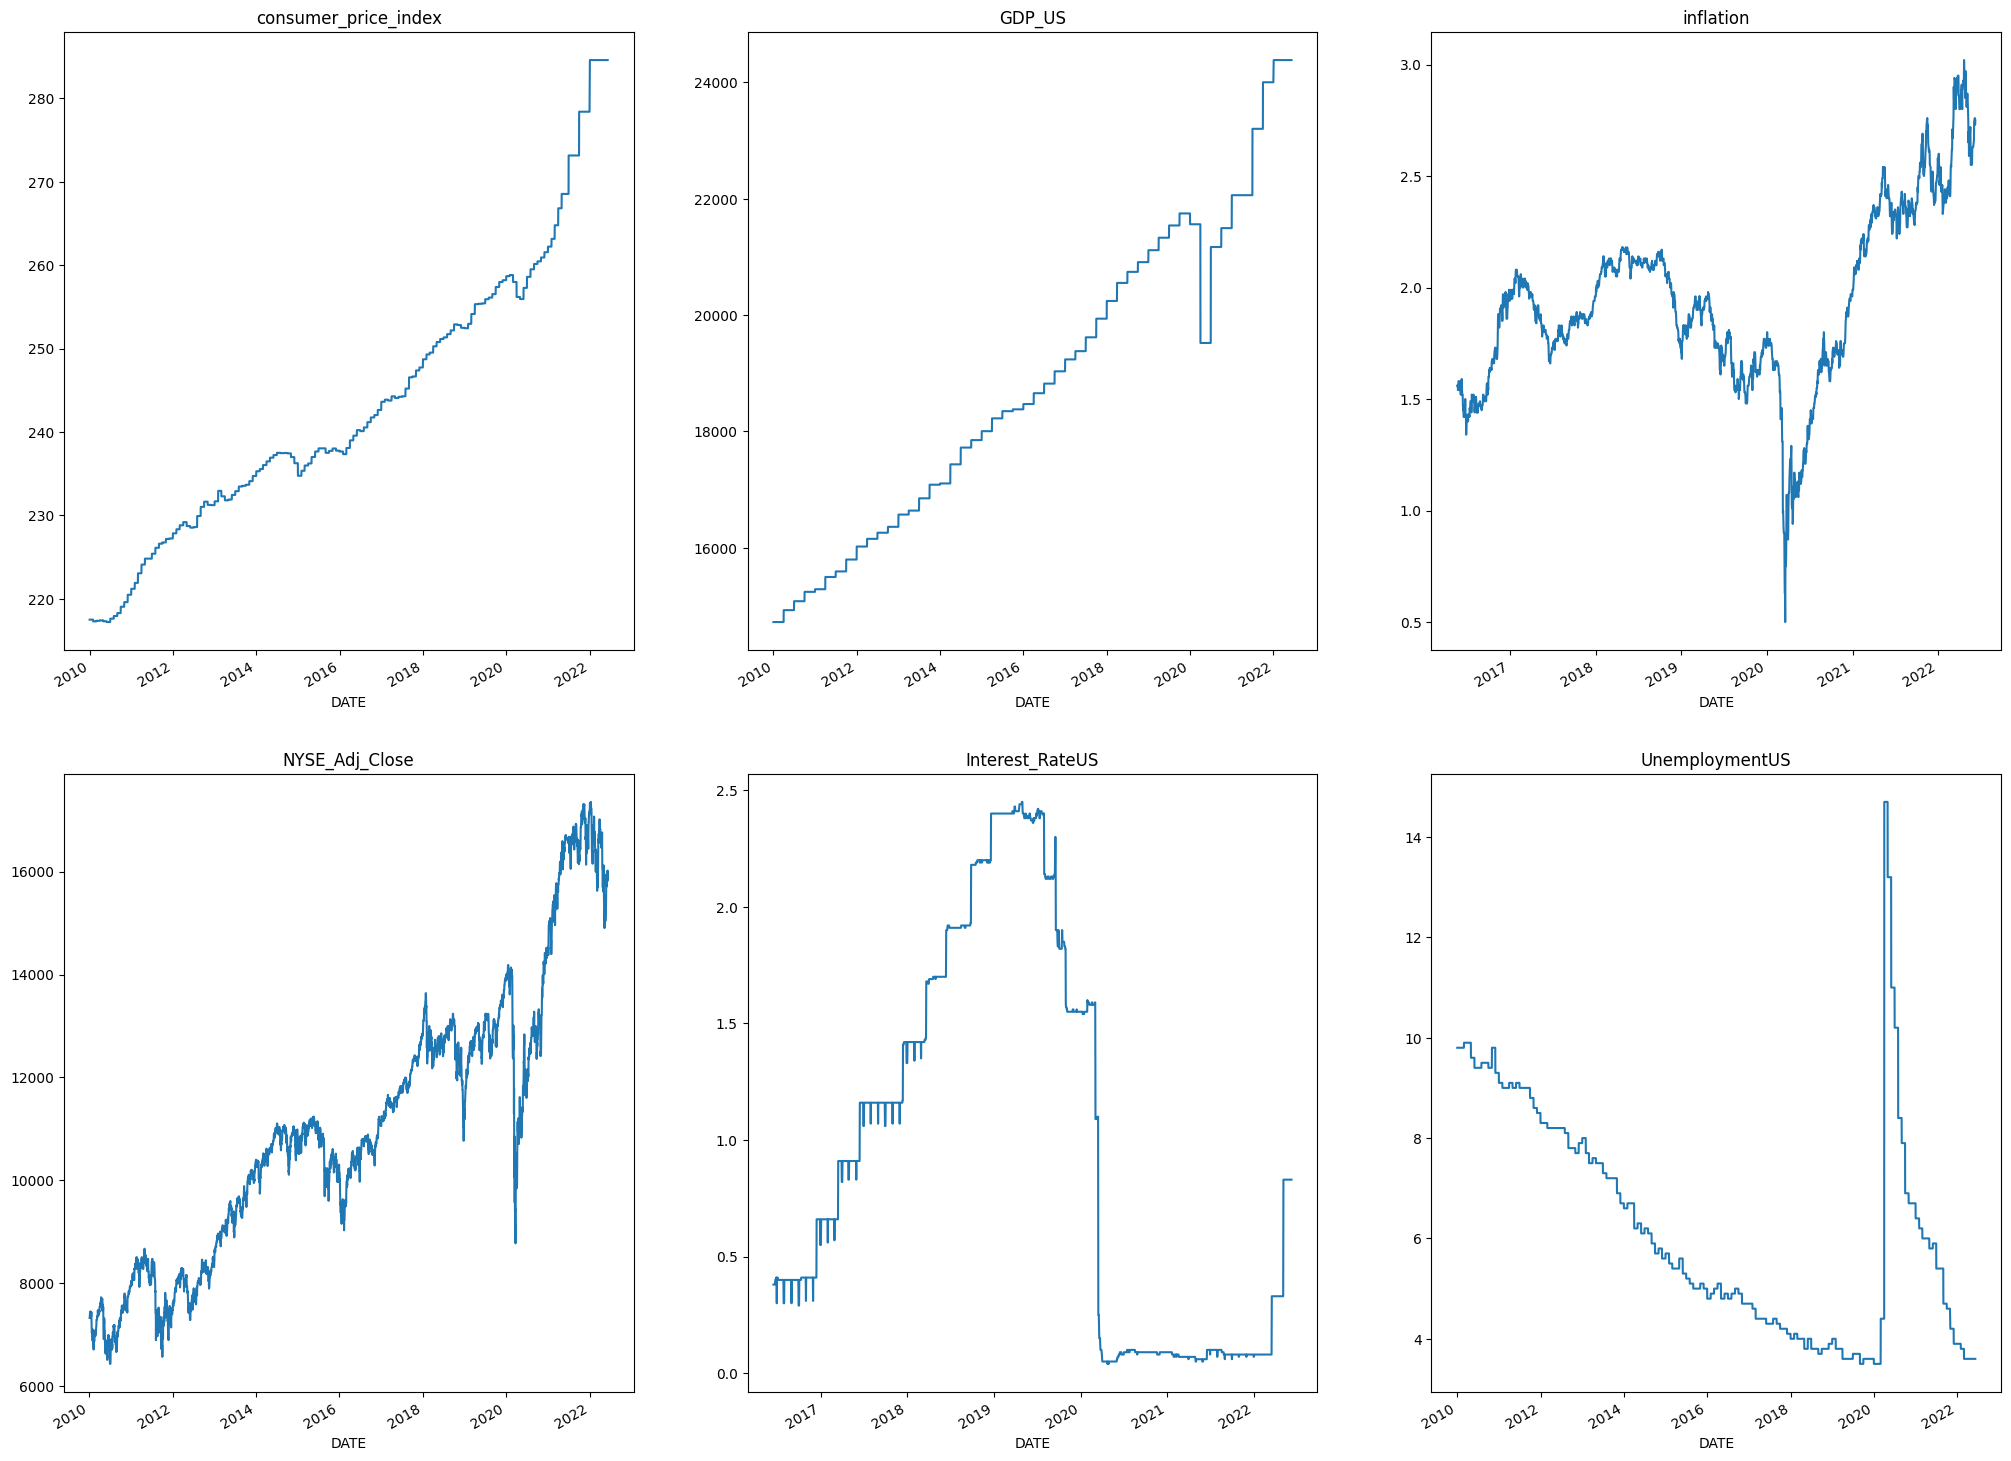

In [17]:
# plot timeseries
fig, ax = plt.subplots(2,3, figsize=(25,20))
ax = ax.ravel() #Flatten ax
for idx, col in enumerate(df_external_regressors.columns):
  df_external_regressors[col].loc[forex_df.index[0]:forex_df.index[-1]].plot(ax=ax[idx])
  ax[idx].set_title(col)

<AxesSubplot: >

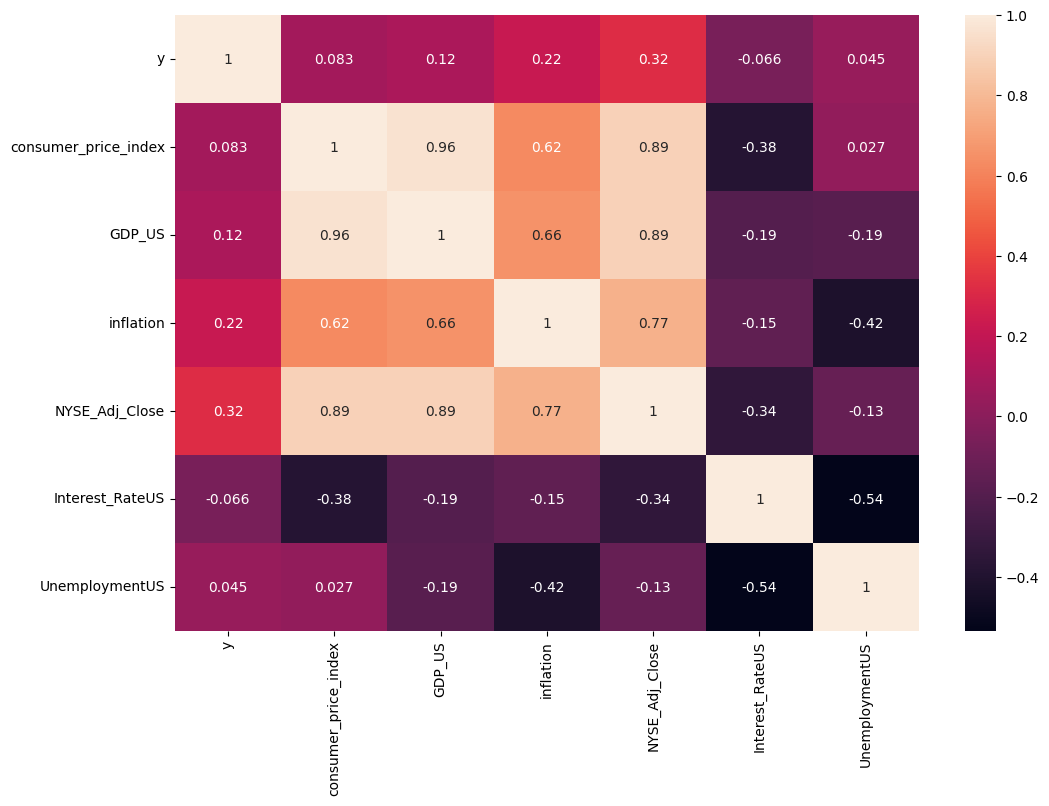

In [18]:
# explore correlation
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(forex_df_reg.corr(), annot=True, ax=ax)

# <span style="color: IndianRed;"> 3. No Sentiment Analysis

### <span style="color: LightSalmon;"> 3.1 Train & Forecast</span>

In [19]:
# Define train/test windows
train_window =  ['2010-01-03','2022-03-30']
test_window =  ['2022-03-31','2022-04-13']

train_window1 =  ['2010-01-03','2022-04-13']
test_window1 =  ['2022-04-14','2022-04-27']

train_window2 =  ['2010-01-03','2022-04-27']
test_window2 =  ['2022-04-28','2022-05-11']

train_window3 =  ['2010-01-03','2022-05-11']
test_window3 =  ['2022-05-12','2022-05-25'] 

In [20]:
%%capture

def train_and_forecast(train_window, test_window):
    # Split datasets
    
    train = forex_df_reg[train_window[0]:train_window[1]].copy()
    test = forex_df_reg[test_window[0]:test_window[1]].copy()

    # Define ext regressors
    extra_regressor = ['consumer_price_index', 'GDP_US', 'inflation', 'NYSE_Adj_Close', 'UnemploymentUS']

    forecasted_ext_regressors = pd.DataFrame()

    # Prepare forecasted data for Prophet
    for ext_reg in extra_regressor:

      # Define tmp_df to forecast ext_reg
      tmp_df = train[['ds', ext_reg]]
      tmp_df['y'] = tmp_df[ext_reg]

      # Define Prophet model with hyperparameters
    m = Prophet(growth='linear', changepoint_prior_scale=0.01)

    # Add custom seasonality
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.add_seasonality(name='weekly', period=7, fourier_order=15)

    # Train model
    m.fit(tmp_df)

    # Make future dataframe and predict
    future = m.make_future_dataframe(test.shape[0], freq='B') # Explain B
    forecast = m.predict(future)

    # Clean and show results
    forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecasted_ext_regressors[ext_reg] = forecast_results.tail(test.shape[0])['yhat'].values

    forecasted_ext_regressors.index = test.index

    # Define Prophet model with hyperparameters
    m = Prophet(growth='linear',n_changepoints=7, changepoint_prior_scale=0.05)

    # Add custom seasonality
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.add_seasonality(name='weekly', period=7, fourier_order=15)

    # Add extra regressor
    for reg in extra_regressor:
      m.add_regressor(name=reg, mode='additive')

    # Train model
    m.fit(train)

    # Make future dataframe and predict
    future = m.make_future_dataframe(test.shape[0], freq='B') # Explain B
    forecast = m.predict(future.merge(pd.concat([train, forecasted_ext_regressors])[extra_regressor], left_on='ds',right_index=True, how='left').fillna(method='pad'))

    # Clean and show results
    forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_results.set_index('ds', inplace=True)

    # Prepare comparison DF
    final_df_results = pd.DataFrame()
    final_df_results['y_pred'] = forecast_results.tail(test.shape[0])['yhat']
    final_df_results['y_true'] = test['y']
     
    return final_df_results

In [21]:
final_df_results = train_and_forecast(train_window,test_window)
final_df_results1 = train_and_forecast(train_window1,test_window1)
final_df_results2 = train_and_forecast(train_window2,test_window2)
final_df_results3 = train_and_forecast(train_window3,test_window3)
forecast_list = [final_df_results, final_df_results1,final_df_results2,final_df_results3]

02:34:06 - cmdstanpy - INFO - Chain [1] start processing
02:34:07 - cmdstanpy - INFO - Chain [1] done processing
02:34:07 - cmdstanpy - INFO - Chain [1] start processing
02:34:07 - cmdstanpy - INFO - Chain [1] done processing
02:34:08 - cmdstanpy - INFO - Chain [1] start processing
02:34:08 - cmdstanpy - INFO - Chain [1] done processing
02:34:08 - cmdstanpy - INFO - Chain [1] start processing
02:34:09 - cmdstanpy - INFO - Chain [1] done processing
02:34:09 - cmdstanpy - INFO - Chain [1] start processing
02:34:09 - cmdstanpy - INFO - Chain [1] done processing
02:34:10 - cmdstanpy - INFO - Chain [1] start processing
02:34:10 - cmdstanpy - INFO - Chain [1] done processing
02:34:10 - cmdstanpy - INFO - Chain [1] start processing
02:34:11 - cmdstanpy - INFO - Chain [1] done processing
02:34:11 - cmdstanpy - INFO - Chain [1] start processing
02:34:11 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
for forecast in forecast_list:
    # Explore results on the forecast window
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=forecast.index, y=forecast['y_true'],
                        mode='lines+markers',
                        name='Real Values'))

    fig.add_trace(go.Scatter(x=forecast.index, y=forecast['y_pred'],
                        mode='lines+markers',
                        name='Predicted Values'))

    fig.update_layout(template='plotly_white')
    fig.show()

### <span style="color: LightSalmon;"> 3.2 Calculating the MAE </span>

Mean MAE: 0.01
MAE%: 1.25%
RMSE: 0.02
Bias: 0.01

5th percetile MAE: 0.00
25th percetile MAE: 0.01
50th percetile MAE: 0.02
75th percetile MAE: 0.02
95th percetile MAE: 0.02


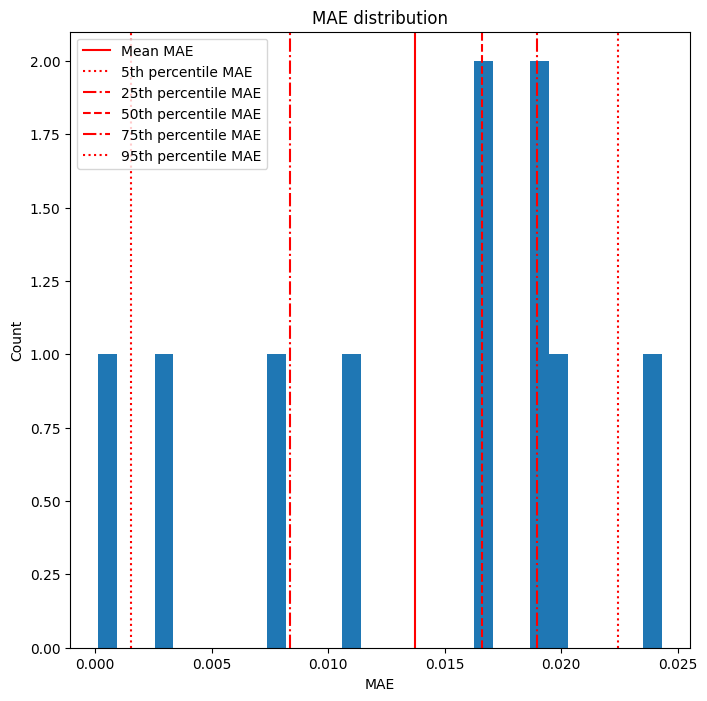

Mean MAE: 0.02
MAE%: 1.79%
RMSE: 0.02
Bias: 0.02

5th percetile MAE: 0.01
25th percetile MAE: 0.02
50th percetile MAE: 0.02
75th percetile MAE: 0.02
95th percetile MAE: 0.03


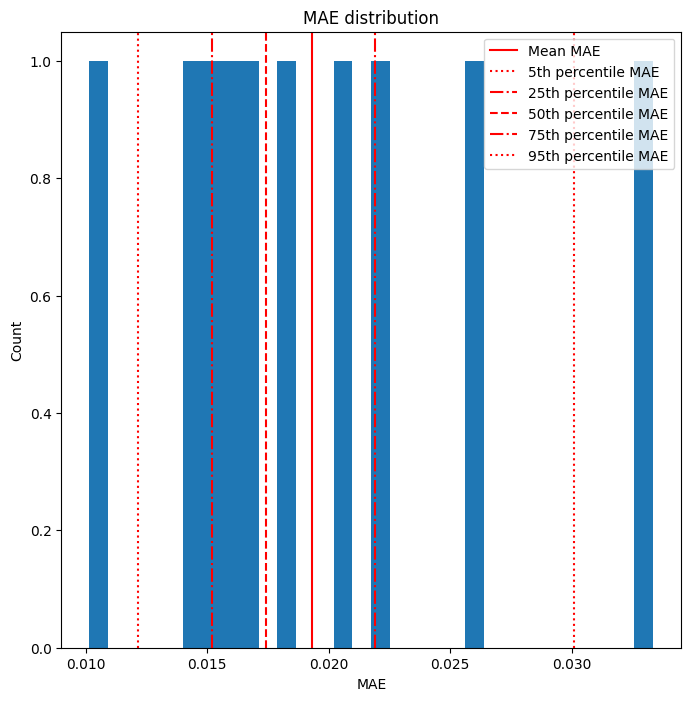

Mean MAE: 0.03
MAE%: 2.93%
RMSE: 0.03
Bias: 0.03

5th percetile MAE: 0.02
25th percetile MAE: 0.03
50th percetile MAE: 0.03
75th percetile MAE: 0.03
95th percetile MAE: 0.04


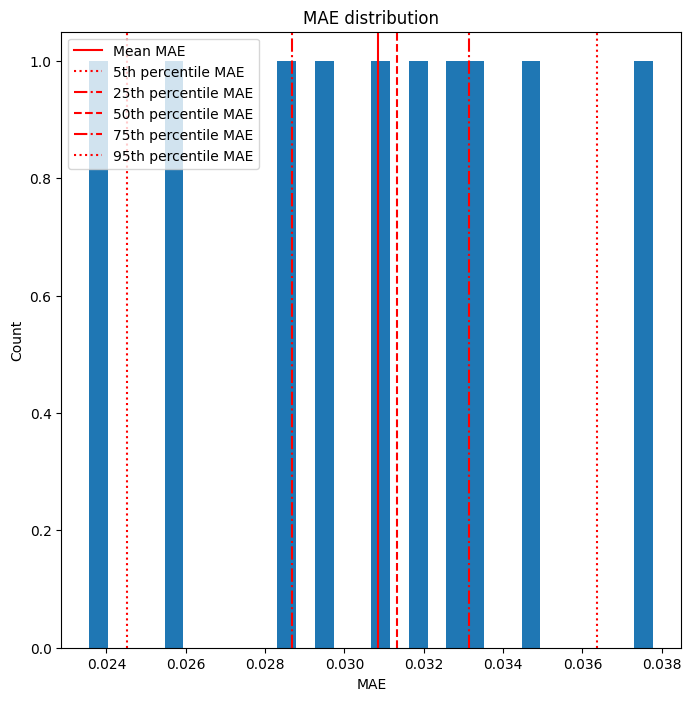

Mean MAE: 0.01
MAE%: 1.41%
RMSE: 0.02
Bias: 0.01

5th percetile MAE: 0.00
25th percetile MAE: 0.01
50th percetile MAE: 0.01
75th percetile MAE: 0.02
95th percetile MAE: 0.03


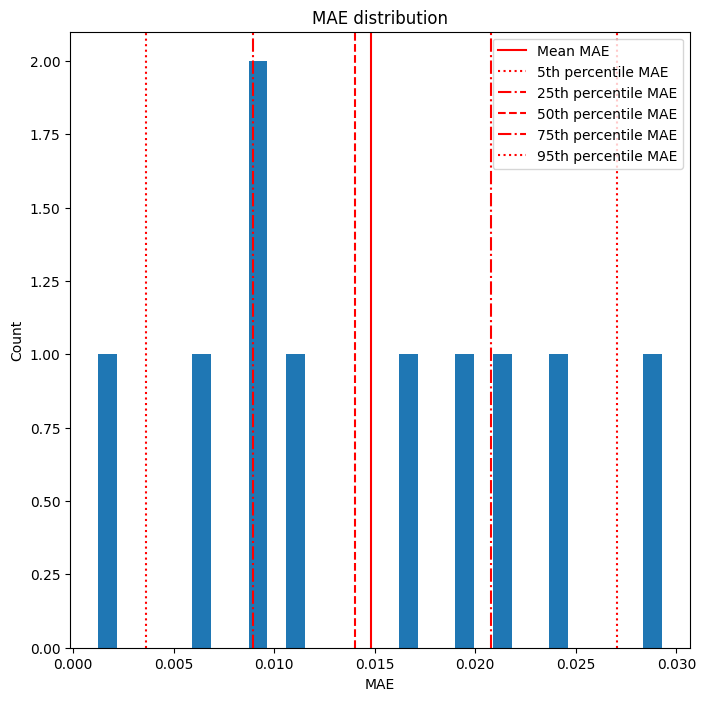

 Mean MAE%: 1.84%


In [23]:
percent_mae =[]
for forecast in forecast_list:
    calc_errors(forecast['y_true'].values, forecast['y_pred'].values)
    perc_mae = mae(forecast['y_true'].values, forecast['y_pred'].values)
    percent_mae.append(perc_mae)

print(f" Mean MAE%: {statistics.mean(percent_mae):.2f}%")

### <span style="color: LightSalmon;"> 3.3 Performing Prediction </span>
For what it concerns the prediction of values from 2022-05-25 onward:

In [24]:
%%capture
# Define train window and pred length
train_window =  ['2010-01-03','2022-05-25']
pred_length =  10


# Split datasets
train = forex_df_reg[train_window[0]:train_window[1]].copy()

# Define ext regressors
extra_regressor = ['consumer_price_index', 'GDP_US', 'inflation', 'NYSE_Adj_Close', 'UnemploymentUS']

forecasted_ext_regressors = pd.DataFrame()

# Prepare forecasted data for Prophet
for ext_reg in extra_regressor:

  # Define tmp_df to forecast ext_reg
  tmp_df = train[['ds', ext_reg]]
  tmp_df['y'] = tmp_df[ext_reg]

  # Define Prophet model with hyperparameters
  m = Prophet(growth='linear', changepoint_prior_scale=0.01)

  # Add custom seasonality
  m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  m.add_seasonality(name='weekly', period=7, fourier_order=15)

  # Train model
  m.fit(tmp_df)

  # Make future dataframe and predict
  future = m.make_future_dataframe(pred_length, freq='B') # Explain B
  forecast = m.predict(future)

  # Clean and show results
  forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecasted_ext_regressors[ext_reg] = forecast_results.tail(pred_length)['yhat'].values

forecasted_ext_regressors.index = pd.bdate_range(start='14/05/2022', end='28/05/2022')

02:34:14 - cmdstanpy - INFO - Chain [1] start processing
02:34:14 - cmdstanpy - INFO - Chain [1] done processing
02:34:15 - cmdstanpy - INFO - Chain [1] start processing
02:34:15 - cmdstanpy - INFO - Chain [1] done processing
02:34:15 - cmdstanpy - INFO - Chain [1] start processing
02:34:16 - cmdstanpy - INFO - Chain [1] done processing
02:34:16 - cmdstanpy - INFO - Chain [1] start processing
02:34:17 - cmdstanpy - INFO - Chain [1] done processing
02:34:17 - cmdstanpy - INFO - Chain [1] start processing
02:34:17 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# Define Prophet model with hyperparameters
m = Prophet(growth='linear',n_changepoints=7, changepoint_prior_scale=0.05)

# Add custom seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='weekly', period=7, fourier_order=15)

# Add extra regressor
for reg in extra_regressor:
  m.add_regressor(name=reg, mode='additive')

# Train model
m.fit(train)

# Make future dataframe and predict
future = m.make_future_dataframe(pred_length, freq='B') # Explain B
forecast = m.predict(future.merge(pd.concat([train, forecasted_ext_regressors])[extra_regressor], left_on='ds',right_index=True, how='left').fillna(method='pad'))

# Clean and show results
forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_results.set_index('ds', inplace=True)
forecast_results.tail(10)

02:34:18 - cmdstanpy - INFO - Chain [1] start processing
02:34:18 - cmdstanpy - INFO - Chain [1] done processing


,yhat,yhat_lower,yhat_upper
ds,,,
2022-05-26,1.080919,1.059391,1.101476
2022-05-27,1.081302,1.060558,1.101076
2022-05-30,1.083229,1.063613,1.103163
2022-05-31,1.083332,1.061681,1.104221
2022-06-01,1.082995,1.062021,1.104475
2022-06-02,1.083072,1.063314,1.102525
2022-06-03,1.083122,1.063260,1.104129
2022-06-06,1.083643,1.063261,1.105697
2022-06-07,1.082915,1.062375,1.103023


In [26]:
# Prepare comparison DF w/ avaiable data and plot
final_df_results = pd.DataFrame()
final_df_results['y_pred'] = forecast_results.tail(pred_length)['yhat']
final_df_results.index = forecast_results.tail(pred_length).index

final_df_results = final_df_results.merge(forex_df, right_index=True, left_index=True, how='left')[['y_pred', 'y']]
final_df_results = final_df_results.tail(pred_length)

fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['y'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['y_pred'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

### <span style="color: LightSalmon;"> 3.4 Calculating the MAE </span>

Mean MAE: 0.01
MAE%: 1.01%
RMSE: 0.01
Bias: 0.01

5th percetile MAE: 0.01
25th percetile MAE: 0.01
50th percetile MAE: 0.01
75th percetile MAE: 0.01
95th percetile MAE: 0.02


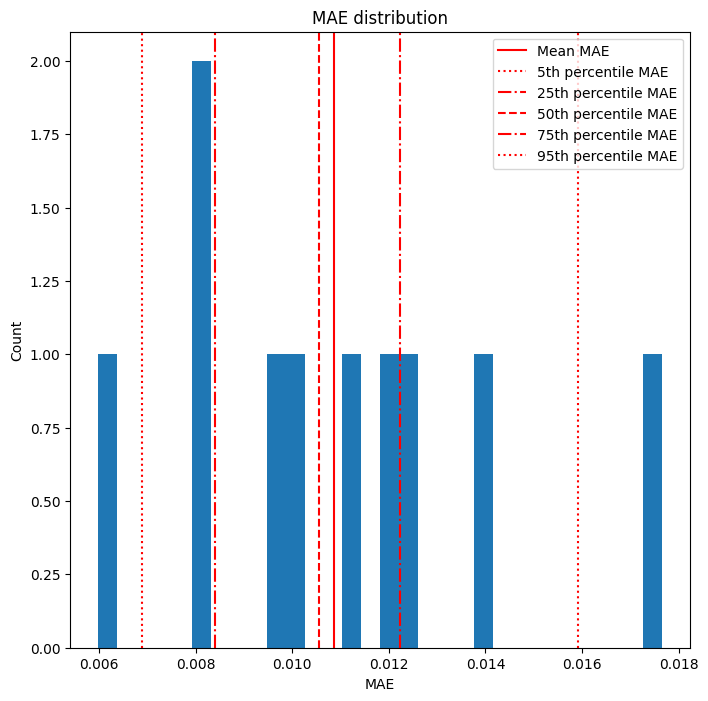

In [27]:
# Analyze the forecast error
final_df = final_df_results.dropna()
calc_errors(final_df['y'].values, final_df['y_pred'].values)

# <span style="color: IndianRed;"> 4. With Sentiment Analysis

### <span style="color: LightSalmon;"> 4.1 Train & Forecast</span>

In [28]:
#Get external regressor function
def get_external_regressors_data():

    # Declare urls
    url_extra = 'https://drive.google.com/file/d/1Fjf_7MOjCIaMwDFWG7TEGu0HejDD5zwB/view?usp=sharing'
    url_nyse = 'https://drive.google.com/file/d/12zlRWly-3RfSBoJntYEO-UcnT54GKMnE/view?usp=sharing'
    url_interest_rate = 'https://drive.google.com/file/d/1TXGNV4Nzhql6aqG_lZNufbGdQT8wNQtk/view?usp=sharing'
    url_unempl = 'https://drive.google.com/file/d/1WxncdsBrzP27Uh0dGevkhUMqOKvqLCxV/view?usp=sharing'
    url_sentiment = 'https://drive.google.com/file/d/1amAkUVsNvUXDfFdePsgds3pALVb2oGzi/view?usp=sharing'

    # Get data
    file_id = url_extra.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_extra = pd.read_csv(dwn_url, parse_dates=['DATE'], delimiter=';')

    file_id = url_nyse.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_nyse = pd.read_csv(dwn_url, parse_dates=['Date'], delimiter=';')

    file_id = url_interest_rate.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_ir = pd.read_csv(dwn_url, parse_dates=['DATE'], delimiter=';')

    file_id = url_unempl.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_unemp = pd.read_csv(dwn_url, parse_dates=['DATE'])

    file_id = url_sentiment.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_sent = pd.read_csv(dwn_url, parse_dates=['date'])

    
    # Set Date as index
    df_extra.set_index('DATE',inplace=True)
    df_nyse.set_index('Date',inplace=True)
    df_ir.set_index('DATE',inplace=True)
    df_unemp.set_index('DATE',inplace=True)
    df_sent.set_index('date',inplace=True)

    # Merge dataframes
    dataframes = [df_extra, df_nyse, df_ir, df_unemp,df_sent]    
    df_merged = reduce(lambda  left,right: pd.merge(left, right, left_index=True, right_index=True, how='left'), dataframes).fillna(method='ffill')

    # Remove useless columns
    df_merged  = df_merged.drop(columns =['Open', 'High', 'Low',	'Close','Volume'])

    # Fix column names
    map_dict = {'CPIAUCSL':'consumer_price_index', 'GDP':'GDP_US', 'T10YIE':'inflation', 'Adj Close': 'NYSE_Adj_Close', 'DFF': 'Interest_RateUS', 'UNRATE': 'UnemploymentUS'}
    df_merged  = df_merged.rename(columns=map_dict)

  
    return df_merged


In [29]:
df_external_regressors = get_external_regressors_data()
df_external_regressors.tail()

,consumer_price_index,GDP_US,inflation,NYSE_Adj_Close,Interest_RateUS,UnemploymentUS,Sentiment
2022-06-02,284.607667,24384.289,2.66,15960.530273,0.83,3.6,0.131773
2022-06-03,284.607667,24384.289,2.74,15797.169922,0.83,3.6,0.068056
2022-06-06,284.607667,24384.289,2.76,15848.450195,0.83,3.6,0.113750
2022-06-07,284.607667,24384.289,2.73,16019.559570,0.83,3.6,-0.321769
2022-06-08,284.607667,24384.289,2.75,15843.833008,0.83,3.6,-0.330556


In [30]:
# merge the data in a single dataframe to explore timeseries correlation
forex_df_reg = forex_df.merge(df_external_regressors, left_index=True, right_index=True, how='left')
forex_df_reg = forex_df_reg.dropna()
forex_df_reg.shape

(838, 9)

In [31]:
# Define train/test windows
train_window =  ['2010-01-03','2022-03-30']
test_window =  ['2022-03-31','2022-04-13']

train_window1 =  ['2010-01-03','2022-04-13']
test_window1 =  ['2022-04-14','2022-04-27']

train_window2 =  ['2010-01-03','2022-04-27']
test_window2 =  ['2022-04-28','2022-05-11']

train_window3 =  ['2010-01-03','2022-05-11']
test_window3 =  ['2022-05-12','2022-05-25'] 

In [32]:
%%capture

def train_and_forecast(train_window, test_window):
    # Split datasets
    
    train = forex_df_reg[train_window[0]:train_window[1]].copy()
    test = forex_df_reg[test_window[0]:test_window[1]].copy()

    # Define ext regressors
    extra_regressor = ['consumer_price_index', 'GDP_US', 'inflation', 'NYSE_Adj_Close', 'UnemploymentUS', 'Sentiment']

    forecasted_ext_regressors = pd.DataFrame()

    # Prepare forecasted data for Prophet
    for ext_reg in extra_regressor:

      # Define tmp_df to forecast ext_reg
      tmp_df = train[['ds', ext_reg]]
      tmp_df['y'] = tmp_df[ext_reg]

      # Define Prophet model with hyperparameters
    m = Prophet(growth='linear', changepoint_prior_scale=0.01)

    # Add custom seasonality
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.add_seasonality(name='weekly', period=7, fourier_order=15)

    # Train model
    m.fit(tmp_df)

    # Make future dataframe and predict
    future = m.make_future_dataframe(test.shape[0], freq='B') # Explain B
    forecast = m.predict(future)

    # Clean and show results
    forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecasted_ext_regressors[ext_reg] = forecast_results.tail(test.shape[0])['yhat'].values

    forecasted_ext_regressors.index = test.index

    # Define Prophet model with hyperparameters
    m = Prophet(growth='linear',n_changepoints=7, changepoint_prior_scale=0.05)

    # Add custom seasonality
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.add_seasonality(name='weekly', period=7, fourier_order=15)

    # Add extra regressor
    for reg in extra_regressor:
      m.add_regressor(name=reg, mode='additive')

    # Train model
    m.fit(train)

    # Make future dataframe and predict
    future = m.make_future_dataframe(test.shape[0], freq='B') # Explain B
    forecast = m.predict(future.merge(pd.concat([train, forecasted_ext_regressors])[extra_regressor], left_on='ds',right_index=True, how='left').fillna(method='pad'))

    # Clean and show results
    forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_results.set_index('ds', inplace=True)

    # Prepare comparison DF
    final_df_results = pd.DataFrame()
    final_df_results['y_pred'] = forecast_results.tail(test.shape[0])['yhat']
    final_df_results['y_true'] = test['y']
     
    return final_df_results

In [33]:
final_df_results = train_and_forecast(train_window,test_window)
final_df_results1 = train_and_forecast(train_window1,test_window1)
final_df_results2 = train_and_forecast(train_window2,test_window2)
final_df_results3 = train_and_forecast(train_window3,test_window3)
forecast_list = [final_df_results, final_df_results1,final_df_results2,final_df_results3]

02:34:25 - cmdstanpy - INFO - Chain [1] start processing
02:34:26 - cmdstanpy - INFO - Chain [1] done processing
02:34:26 - cmdstanpy - INFO - Chain [1] start processing
02:34:26 - cmdstanpy - INFO - Chain [1] done processing
02:34:26 - cmdstanpy - INFO - Chain [1] start processing
02:34:26 - cmdstanpy - INFO - Chain [1] done processing
02:34:27 - cmdstanpy - INFO - Chain [1] start processing
02:34:27 - cmdstanpy - INFO - Chain [1] done processing
02:34:27 - cmdstanpy - INFO - Chain [1] start processing
02:34:27 - cmdstanpy - INFO - Chain [1] done processing
02:34:27 - cmdstanpy - INFO - Chain [1] start processing
02:34:28 - cmdstanpy - INFO - Chain [1] done processing
02:34:28 - cmdstanpy - INFO - Chain [1] start processing
02:34:28 - cmdstanpy - INFO - Chain [1] done processing
02:34:28 - cmdstanpy - INFO - Chain [1] start processing
02:34:29 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
for forecast in forecast_list:
    # Explore results on the forecast window
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=forecast.index, y=forecast['y_true'],
                        mode='lines+markers',
                        name='Real Values'))

    fig.add_trace(go.Scatter(x=forecast.index, y=forecast['y_pred'],
                        mode='lines+markers',
                        name='Predicted Values'))

    fig.update_layout(template='plotly_white')
    fig.show()

### <span style="color: LightSalmon;"> 4.2 Calculating the MAE </span>

Mean MAE: 0.01
MAE%: 1.33%
RMSE: 0.02
Bias: 0.01

5th percetile MAE: 0.00
25th percetile MAE: 0.01
50th percetile MAE: 0.01
75th percetile MAE: 0.02
95th percetile MAE: 0.03


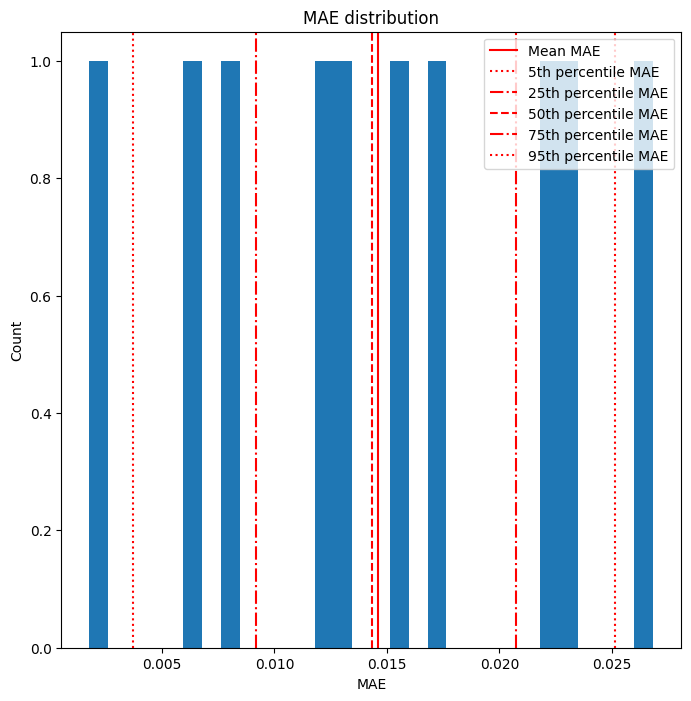

Mean MAE: 0.02
MAE%: 1.72%
RMSE: 0.02
Bias: 0.02

5th percetile MAE: 0.01
25th percetile MAE: 0.01
50th percetile MAE: 0.02
75th percetile MAE: 0.02
95th percetile MAE: 0.03


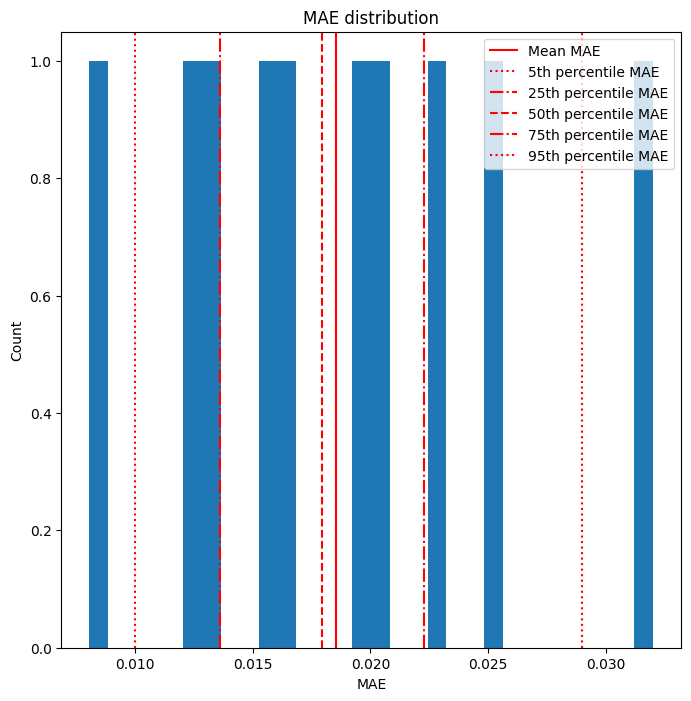

Mean MAE: 0.03
MAE%: 2.60%
RMSE: 0.03
Bias: 0.03

5th percetile MAE: 0.02
25th percetile MAE: 0.03
50th percetile MAE: 0.03
75th percetile MAE: 0.03
95th percetile MAE: 0.03


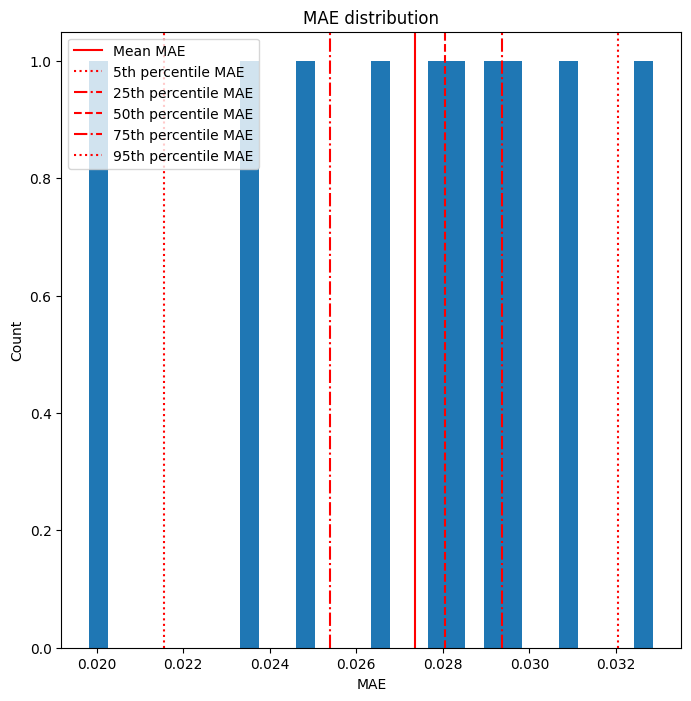

Mean MAE: 0.02
MAE%: 1.52%
RMSE: 0.02
Bias: 0.02

5th percetile MAE: 0.00
25th percetile MAE: 0.01
50th percetile MAE: 0.02
75th percetile MAE: 0.02
95th percetile MAE: 0.03


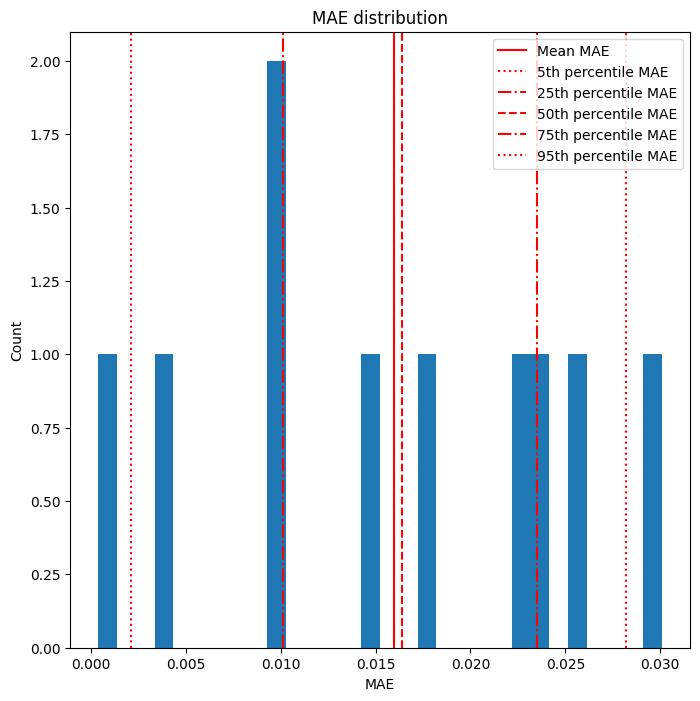

 Mean MAE%: 1.79%


In [35]:
percent_mae =[]
for forecast in forecast_list:
    calc_errors(forecast['y_true'].values, forecast['y_pred'].values)
    perc_mae = mae(forecast['y_true'].values, forecast['y_pred'].values)
    percent_mae.append(perc_mae)

print(f" Mean MAE%: {statistics.mean(percent_mae):.2f}%")

### <span style="color: LightSalmon;"> 4.3 Performing Prediction </span>
For what it concerns the prediction of values from 2022-05-25 onward:

In [36]:
%%capture
# Define train window and pred length
train_window =  ['2010-01-03','2022-05-25']
pred_length =  10


# Split datasets
train = forex_df_reg[train_window[0]:train_window[1]].copy()

# Define ext regressors
extra_regressor = ['consumer_price_index', 'GDP_US', 'inflation', 'NYSE_Adj_Close', 'UnemploymentUS', 'Sentiment']

forecasted_ext_regressors = pd.DataFrame()

# Prepare forecasted data for Prophet
for ext_reg in extra_regressor:

  # Define tmp_df to forecast ext_reg
  tmp_df = train[['ds', ext_reg]]
  tmp_df['y'] = tmp_df[ext_reg]

  # Define Prophet model with hyperparameters
  m = Prophet(growth='linear', changepoint_prior_scale=0.01)

  # Add custom seasonality
  m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  m.add_seasonality(name='weekly', period=7, fourier_order=15)

  # Train model
  m.fit(tmp_df)

  # Make future dataframe and predict
  future = m.make_future_dataframe(pred_length, freq='B') # Explain B
  forecast = m.predict(future)

  # Clean and show results
  forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecasted_ext_regressors[ext_reg] = forecast_results.tail(pred_length)['yhat'].values

forecasted_ext_regressors.index = pd.bdate_range(start='14/05/2022', end='28/05/2022')

02:34:30 - cmdstanpy - INFO - Chain [1] start processing
02:34:30 - cmdstanpy - INFO - Chain [1] done processing
02:34:30 - cmdstanpy - INFO - Chain [1] start processing
02:34:30 - cmdstanpy - INFO - Chain [1] done processing
02:34:31 - cmdstanpy - INFO - Chain [1] start processing
02:34:31 - cmdstanpy - INFO - Chain [1] done processing
02:34:31 - cmdstanpy - INFO - Chain [1] start processing
02:34:31 - cmdstanpy - INFO - Chain [1] done processing
02:34:32 - cmdstanpy - INFO - Chain [1] start processing
02:34:32 - cmdstanpy - INFO - Chain [1] done processing
02:34:32 - cmdstanpy - INFO - Chain [1] start processing
02:34:32 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# Define Prophet model with hyperparameters
m = Prophet(growth='linear',n_changepoints=7, changepoint_prior_scale=0.05)

# Add custom seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='weekly', period=7, fourier_order=15)

# Add extra regressor
for reg in extra_regressor:
  m.add_regressor(name=reg, mode='additive')

# Train model
m.fit(train)

# Make future dataframe and predict
future = m.make_future_dataframe(pred_length, freq='B') # Explain B
forecast = m.predict(future.merge(pd.concat([train, forecasted_ext_regressors])[extra_regressor], left_on='ds',right_index=True, how='left').fillna(method='pad'))

# Clean and show results
forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_results.set_index('ds', inplace=True)
forecast_results.tail(10)

02:34:32 - cmdstanpy - INFO - Chain [1] start processing
02:34:32 - cmdstanpy - INFO - Chain [1] done processing


,yhat,yhat_lower,yhat_upper
ds,,,
2022-05-26,1.072649,1.060616,1.085171
2022-05-27,1.071916,1.059478,1.085107
2022-05-30,1.074370,1.060760,1.086489
2022-05-31,1.074894,1.061784,1.087401
2022-06-01,1.074896,1.062542,1.088238
2022-06-02,1.074293,1.061279,1.087155
2022-06-03,1.073929,1.061476,1.086864
2022-06-06,1.073531,1.061438,1.085961
2022-06-07,1.072531,1.059160,1.085315


In [38]:
# Prepare comparison DF w/ avaiable data and plot
final_df_results = pd.DataFrame()
final_df_results['y_pred'] = forecast_results.tail(pred_length)['yhat']
final_df_results.index = forecast_results.tail(pred_length).index

final_df_results = final_df_results.merge(forex_df, right_index=True, left_index=True, how='left')[['y_pred', 'y']]
final_df_results = final_df_results.tail(pred_length)

fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['y'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['y_pred'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

### <span style="color: LightSalmon;"> 4.4 Calculating the MAE </span>

Mean MAE: 0.00
MAE%: 0.25%
RMSE: 0.00
Bias: 0.00

5th percetile MAE: 0.00
25th percetile MAE: 0.00
50th percetile MAE: 0.00
75th percetile MAE: 0.00
95th percetile MAE: 0.01


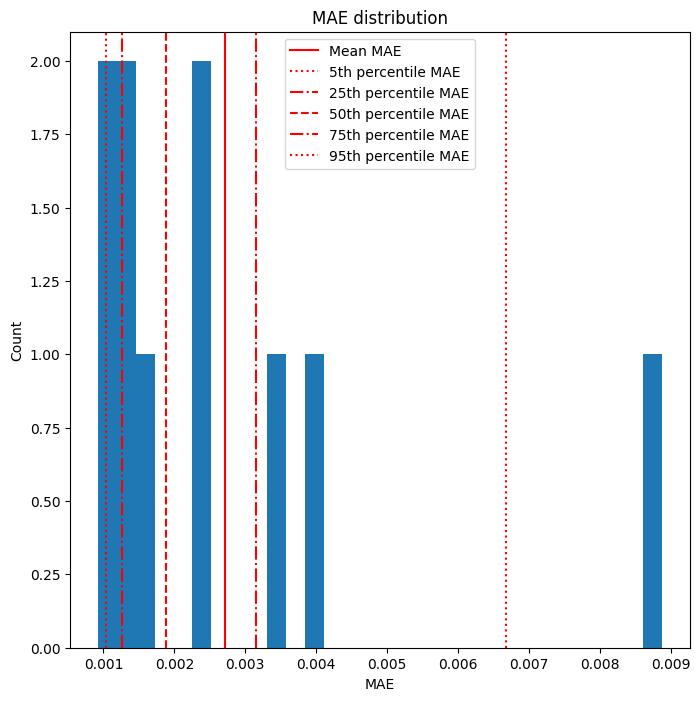

In [39]:
# Analyze the forecast error
final_df = final_df_results.dropna()
calc_errors(final_df['y'].values, final_df['y_pred'].values)

# <span style="color: IndianRed;"> 5. Final Thoughts

- It seems that the sentiment regressor imporves significantly our prediction. Excluding the dip that occured June 2nd 2022. Our model still performed really well, with a mean absolute error of 0.25%. 
- Looking at the MAE scores from the training and forcasting part we can see that we don't have an overfitting/underfitting problem as the scores are not too far off the MAE score of the prediction part.
- We could see in the data exploratory analysis part that some of the external regressors are correlated with each other. However I still decided to keep them as removing them might hugely affect our forecasting as we would lose a lot of information. However, an interesting approach could be made. We can try applying vif to measure for collinearity between variables and from there we can perform feature selection, by removing one feature each time and calculating the vif again and from there we determine if this would improve our correlation 'problem'. 
- However, multicollinearity has little bearing on a model’s predictive performance. This can be measured by performing training and forecasting twice. Once with all the external regressors and once without the regressor that affects highly the vif scores.